## IMA205 Challenge 2023 - Cardiac Pathology Prediction - Nicolas BOISSEAU ##

## Challenge instruction #
## https://www.kaggle.com/competitions/ima205-challenge-2023/overview ##

## Introduction ##

Analysis of cardiac function is essential in clinical cardiology for disease diagnosis, patient management and therapy decision. The challenge focuses on four cardiac pathologies that might go unnoticed at first, but can ultimately become life-threatening. Complications include heart failure and sudden cardiac arrest.

It is important to identify these conditions as early as possible to guide treatment and prevent complications. This is why several approaches for automatic diagnosis from cardiac magnetic resonance imaging (CMRI) have been proposed in the last years (non-invasive computer-aided diagnosis (CAD)).

## Goal of the challenge ##

The goal of this challenge is to classify MRI images of the heart among five different diagnostic classes:

- Healthy controls
- Myocardial infarction
- Dilated cardiomyopathy
- Hypertrophic cardiomyopathy
- Abnormal right ventricle

In order to do so, you will extract features such as the volume of the anatomical structures at two different time points in the cardiac cycle (end of the cardiac contraction and end of the dilation), the thickness of the cardiac muscle, and the ejection fractions. After that, you will use machine learning algorithms to classify the subjects.

## Data ##

You will use a dataset of 150 subjects with their MRI images and, when available, their corresponding segmentations and metadata (subject height and weight). Data has already been randomly split into a training-validation set (two thirds = 100 subjects) and a test set (one third = 50 subjects). You only have the classification (made by clinicians) of the training-validation set. 

The goal of the challenge is to estimate the correct class of each subject in the test set. You can only use the data provided in this challenge

The class labels ("Category" field in the metadata) are mapped thusly to diagnostic classes:

- '0' - Healthy control
- '1' - Myocardial infarction
- '2' - Dilated cardiomyopathy
- '3' - Hypertrophic cardiomyopathy
- '4' - Abnormal right ventricle

For each subject, two MRI images are provided : one image at end diastole (end of dilation in the cardiac cycle) and one image at end systole (end of contraction). Each MRI image is a 3D volume containing the heart and adjacent structures. Comparing the cardiac anatomy between these two time points should help you classify subjects.

To help you achieve your goal, you are provided for each image in the training-validation set with a corresponding 3D segmentation of the cardiac anatomy in three substructures: left ventricle cavity, right ventricle cavity, and myocardium (cardiac muscle). Each segmentation map consists in a 3D multi-label mask with the corresponding labels:

- 0 - Background
- 1 - Right ventricle cavity
- 2 - Myocardium
- 3 - Left ventricle cavity

You can use these segmentations to extract relevant features about the subject's cardiac anatomy. In the test set, you are only given partial segmentations. Specifically, the left ventricle cavity label (3) is missing (replaced by background). Therefore you may find useful as an intermediate step to perform left ventricle segmentation, using any suitable computer vision or machine learning technique.

## Feature extraction ##

You can use all features you would like. A list of references describing very well-known features can be found at the end of this page but you can find many more articles in the literature. You can use Pubmed, Google Scholar or simply Google to look for them. By using the network of Télécom Paris or its VPN, you will have automatically access to most of the scientific journals.

## Evaluation ##

The evaluation of the challenge will be based on 1) the ranking in the leaderboard, 2) a report and 3) the quality of your code.

The students who will have the best rankings in the (private) leaderboard at the end of the challenge will have between 1 and 4 points more in the final grade (depending on the result).

You will have to write a report where you will thoroughly explain the extraction of the features, the classification algorithms you used, why you chose them and the potential pre- and post-processing (such as the LV cavity segmentation). You will have to explain the results saying if and why you expected those results. Be careful ! You will be penalised if you simply do a list of results like "I tried this algorithm but it did not work so I tried another one and so forth …" !!

Write a proper, commented and clean code in Python 3. We will test it and if it does not work you will have a penalty on the grade. Please write at the beginning of your code the version of the libraries you used. You can write a set of functions with a main one - we will only run the main function - or a jupyter-notebook.

Everything, report and code, must be uploaded to E-campus in the section Challenge before the end of the challenge

## Metrics ##

As ranking metric, we will use the Categorization Accuracy, which is defined as:

where $N$ is the number of test subjects, $y_i$ the ground truth label for subject $i$, and $f_i$ the predicted label.

Methods and software
You must use Python 3 as programming language. We strongly suggest that you use numpy and scikit-learn.

You can use any pre-processing and post-processing - coded by you or correctly referenced in the report.

All CMR images and segmentation maps in the dataset are saved as NIfTI files (.nii extensions). You can read/write such images using one of several python libraries, such as nibabel or TorchIO.

To visualize MRI images and segmentations, you may directly display 2D slices in a jupyter notebook using matplotlib after loading the image, or you may use dedicated visualization software such as ParaView (after loading the AnalyzeNIfTIReaderWriter plugin), 3D Slicer and others.

## References ##

For the (optional) left ventricle segmentation:

https://ieeexplore.ieee.org/document/4776520
https://www.sciencedirect.com/science/article/pii/S136184150400026X
https://www.sciencedirect.com/science/article/abs/pii/S0010482505000430
https://link.springer.com/chapter/10.1007/978-3-642-31196-3_3#chapter-info
https://link.springer.com/chapter/10.1007/978-3-642-28326-0_11#chapter-info
https://link.springer.com/chapter/10.1007/978-3-319-10470-6_73#chapter-info

For the classification:

https://link.springer.com/chapter/10.1007/978-3-319-75541-0_15
https://link.springer.com/chapter/10.1007/978-3-319-75541-0_13
https://link.springer.com/chapter/10.1007/978-3-319-75541-0_11
https://ieeexplore.ieee.org/document/8360453

## Library import ##

In [1]:
# library
                                                                    ##3.9.16 (main, Dec  7 2022, 01:11:51) 
                                                                    ##[GCC 9.4.0]
import matplotlib.pyplot as plt                                     ##Version: 3.7.1
import numpy as np                                                  ##Version 1.22.4
import pandas as pd                                                 ##Version: 1.5.3
import nibabel as nib                                               ##Version: 3.0.2
import glob
import random
import cv2
import os
from skimage.filters import gaussian                                ##Version: 0.19.3
from skimage.segmentation import active_contour
from skimage.segmentation import flood, flood_fill
from sklearn.preprocessing import StandardScaler, MinMaxScaler      ##Version: 1.2.2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
# Define variable for the kaggle
#accesible in both mode value to string and string to value

diseases_category = {
  0: "Healthy controls",
  1: "Myocardial infarction",
  2: "Dilated cardiomyopathy",
  3: "Hypertrophic cardiomyopathy",
  4: "Abnormal right ventricle",

  "Healthy controls": 0,
  "Myocardial infarction": 1,
  "Dilated cardiomyopathy": 2,
  "Hypertrophic cardiomyopathy": 3,
  "Abnormal right ventricle": 4
}

segmentation_label = {
  0: "Background",
  1: "Right ventricle cavity",
  2: "Myocardium",
  3: "Left ventricle cavity",
  
  "Background": 0,
  "Right ventricle cavity": 1,
  "Myocardium" :2,
  "Left ventricle cavity": 3
}

subject_num_train_start = 1
subject_num_train_stop = 100
subject_num_test_start = 101
subject_num_test_stop = 150

In [3]:
# Import the data from my drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define my working path depending if I work on Colab on or my personal environnement

if 'google.colab' in str(get_ipython()):
  Train_path = "/content/drive/MyDrive/Colab Notebooks/Train"
  Test_path = "/content/drive/MyDrive/Colab Notebooks/Test"
  metaTrain_path = "/content/drive/MyDrive/Colab Notebooks/metaDataTrain.csv"
  metaTest_path = "/content/drive/MyDrive/Colab Notebooks/metaDataTest.csv"
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')
  Train_path = "./Train"
  Test_path = "./Test"
  metaTrain_path = "./metaDataTrain.csv"
  metaTest_path = "./metaDataTest.csv"

# Modify working_dir if you are not using Google Colab)
Working_directory="./" 

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


## Main code ##

In [59]:
# Main code | to run all the steps

## Observe random subject hearth MRI slices from training set

# display_random_subject_MRI_images_slices(Train_path, segmentation=False)

## Observe random subject hearth MRI slices from test set before segmentation

# display_random_subject_MRI_images_slices(Test_path, segmentation=False)

## Lets first segment the left ventricle cavity on the Test set 

left_ventricle_segmentation_test_set()

## Observe random subject hearth MRI slices from test set after segmentation

#display_random_subject_MRI_images_slices(Test_path, segmentation=True)

## Extract the features for the training set and save it as training_features.csv

save_features(Train_path)

# Extract the features for the test set and save it as test_features.csv

save_features(Test_path)

# Classification using Random Forest Classifier

y_pred, y_pred_df, RF, X_train_df = classify()
print(y_pred)

#Observe the extracted features importances for the classification

observe_features_importances(RF, X_train_df)


Best Validation Score: 0.95
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
Random Forest test score : 0.9
[1 4 0 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 3 4 0 0 3 1 2 1 4 2 4 1 4 3 2 3 3 1
 3 1 0 2 1 2 1 4 2 3 1 1 1]


NameError: name 'observe_features_importances' is not defined

## Data exploration and visualization ##

In [49]:
# Data exploration and visualization

def display_random_subject_MRI_images_slices(folder, segmentation = False):


  
  if ((folder == Train_path) and (segmentation == False)):    
    # example of image data from the training folder
    random_string = '{:03}'.format(random.randint(1, 100))
    end_diastole_volume_path = folder + "/"+ random_string + "/" + random_string + "_ED.nii"
    end_diastole_seg_path = folder + "/"+ random_string + "/" + random_string + "_ED_seg.nii"
    end_systole_volume_path = folder + "/"+ random_string + "/" + random_string + "_ES.nii"
    end_systole_seg_path = folder + "/"+ random_string + "/" + random_string + "_ES_seg.nii"
  elif((folder == Test_path) and (segmentation == False)): 
    random_string = '{:03}'.format(random.randint(101, 150))
    # example of image data from the test folder before segmentation
    end_diastole_volume_path = folder + "/"+ random_string + "/" + random_string + "_ED.nii"
    end_diastole_seg_path = folder + "/"+ random_string + "/" + random_string + "_ED_seg.nii"
    end_systole_volume_path = folder + "/"+ random_string + "/" + random_string + "_ES.nii"
    end_systole_seg_path = folder + "/"+ random_string + "/" + random_string + "_ES_seg.nii"
  elif ((folder == Test_path) and (segmentation == True)):
    # example of image data from the test folder after segmentation
    random_string = '{:03}'.format(random.randint(101, 150))
    end_diastole_volume_path = folder + "/"+ random_string + "/" + random_string + "_ED.nii"
    end_diastole_seg_path = folder + "/"+ random_string + "/" + random_string + "_LV_ED_seg.nii"
    end_systole_volume_path = folder + "/"+ random_string + "/" + random_string + "_ES.nii"
    end_systole_seg_path = folder + "/"+ random_string + "/" + random_string + "_LV_ES_seg.nii"
  else:
    raise ValueError("Mention wrong path!")

  print("Path: " + folder + "/"+ random_string)

  # load the image and segmentation files using nibabel
  diastole_volume = nib.load(end_diastole_volume_path).get_fdata()
  diastole_seg = nib.load(end_diastole_seg_path).get_fdata()
  systole_volume = nib.load(end_systole_volume_path).get_fdata()
  systole_seg = nib.load(end_systole_seg_path).get_fdata()

  # plot the image and segmentation using Matplotlib

  fig, axs = plt.subplots(4, diastole_volume.shape[2], figsize=(20, 20))

  for i in range(diastole_volume.shape[2]):
      axs[0, i].imshow(diastole_volume[:, :, i])
      axs[1, i].imshow(diastole_seg[:, :, i])
      axs[2, i].imshow(systole_volume[:, :, i])
      axs[3, i].imshow(systole_seg[:, :, i])
      
  plt.tight_layout()
  plt.show()


Path: ./Train/069


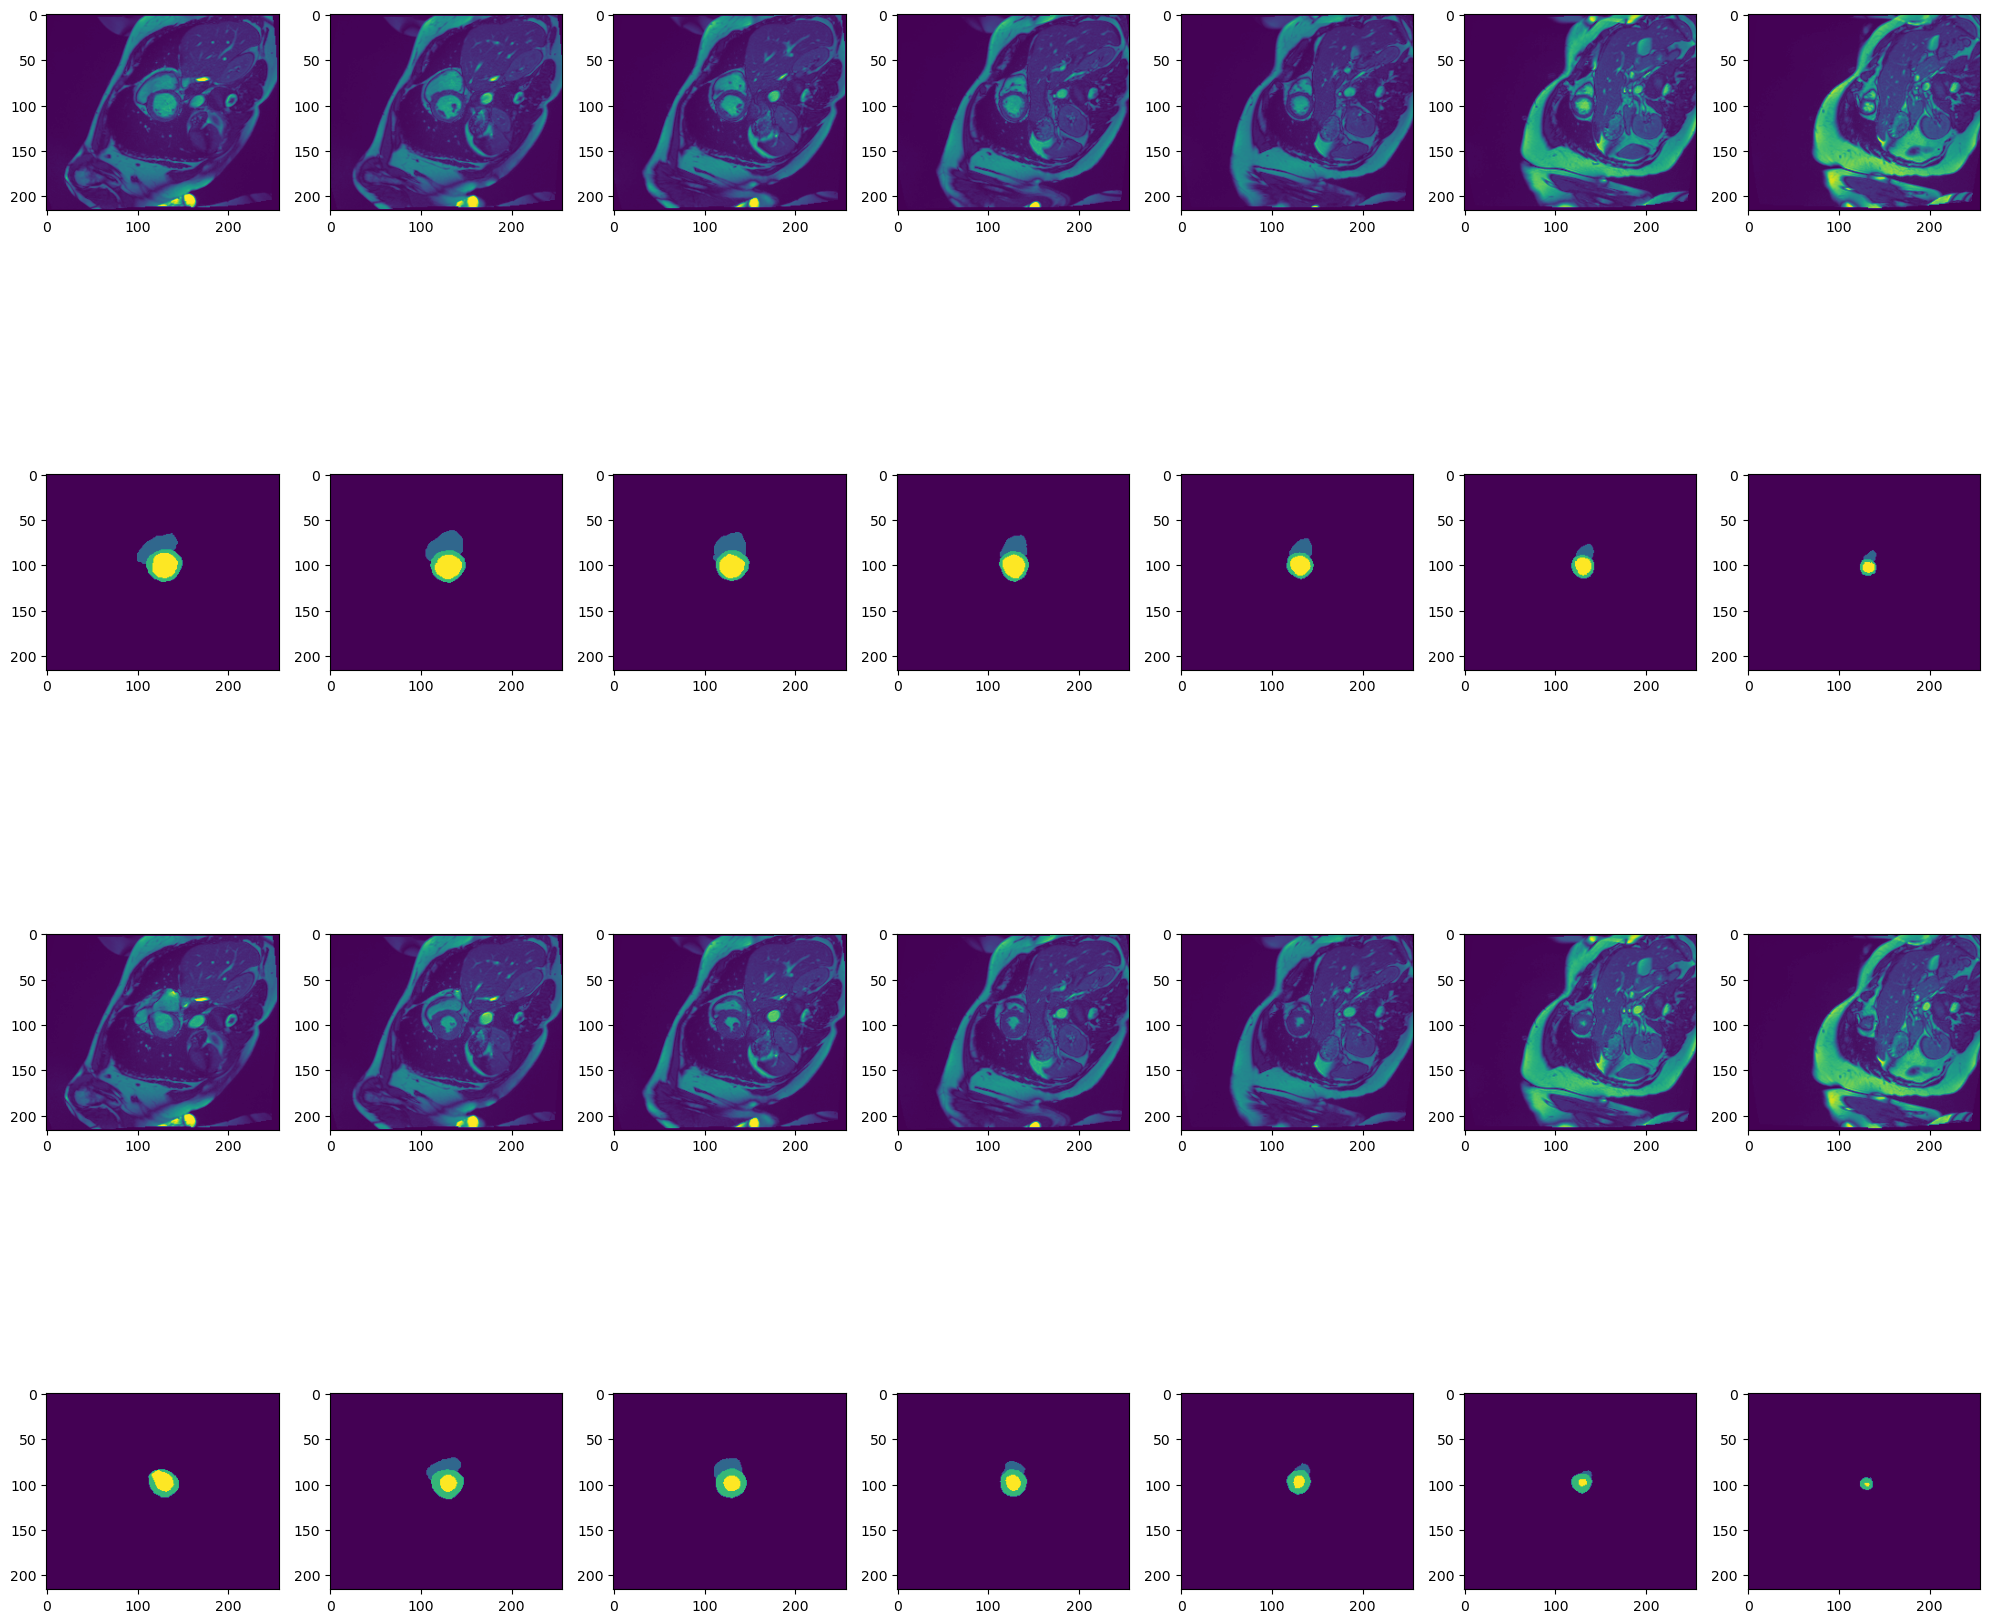

In [6]:
display_random_subject_MRI_images_slices(Train_path, segmentation=False)

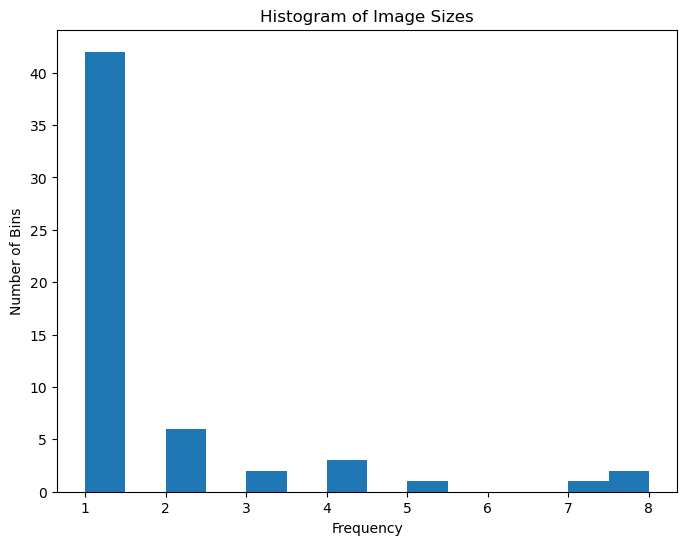

In [7]:
# Check the image size

end_diastole_volume_list = glob.glob(Train_path + "/*" + "/*_ED.nii")
end_diastole_seg_list = glob.glob(Train_path + "/*" + "/*_ED_seg.nii")
end_systole_volume_list = glob.glob(Train_path + "/*" + "/*_ES.nii")
end_systole_seg_list = glob.glob(Train_path + "/*" + "/*_ES_seg.nii")

image_size = []
# Loop over each image path
for end_diastole_volume in end_diastole_volume_list:
    # Read the image
    img = nib.load(end_diastole_volume).get_fdata()
    # Get the size of the image and append it to the lists
    image_size.append(img.shape)

size_counts = Counter(image_size)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.hist(size_counts.values(), bins='auto')
ax.set_title("Histogram of Image Sizes")
ax.set_xlabel("Frequency")
ax.set_ylabel("Number of Bins")

plt.show()

- With this part of the code, I just checked I have different image sizes. So some pre-processing or post-processing should be done. In order to take this into account for the feature extraction.

In [8]:
# Lets have a quick overview of the metadataTrain

meta_data_train = pd.read_csv(metaTrain_path)
meta_data_train.head()

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0


In [9]:
# Lets have a quick overview of the metadataTest

meta_data_test = pd.read_csv(metaTest_path)
meta_data_test.head()

,Id,Height,Weight
0,101,167.0,89.0
1,102,137.0,35.0
2,103,167.0,116.0
3,104,160.0,98.0
4,105,174.0,64.0


## Cardiac Pathology  Distribution ##

- Since we are gonna apply machine learning algorithm, it is mandatory to look at the overall distribution of the disease in the datasets. In this step I mostly want to check the data and prevent any unbalanced dataset learning.

- The results indicates the datasets has already been balanced and that we won't face this problem

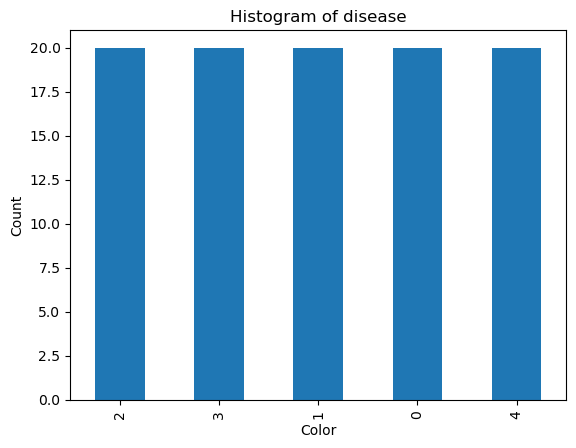

In [10]:
# Cardiac Pathology Proportion

# count the number of occurrences of each category
counts = meta_data_train['Category'].value_counts()

# plot the result as a histogram
counts.plot(kind='bar')

# set the title and axis labels
plt.title('Histogram of disease')
plt.xlabel('Color')
plt.ylabel('Count')

# show the plot
plt.show()

## Features extraction ##

From all the data available, here is the list of the 14 features I wish to acquire:

- 1: volume of the left ventricle at the end of diastole (lv_vol_ed)
- 2: volume of the left ventricle at the end of systole (lv_vol_es)
- 3: volume of the right ventricle at the end of diastole (rv_vol_ed)
- 4: volume of the right ventricle at the end of systole (rv_vol_es)
- 5: end of diastole myocardium volume (myo_vol_ed)
- 6: end of systole myocardium volume (myo_vol_es)
- 7: ejection fractions of left ventricle cavity (lv_ef)
- 8: ejection fractions of right ventricle cavity (rv_ef)
- 9: ratio between RV and LV volume at end diastole (r_rv_lv_ed)
- 10: ratio between RV and LV volume at end systole (r_rv_lv_es)
- 11: ratio between Myocardium and LV volume at end diastole (r_myo_lv_ed)
- 12: ratio between Myocardium and LV volume at end systole (r_myo_lv_es)
- 13: body mass index (bmi)

In [50]:
def extract_Height_Weight(subject_num, folder):

  # Read the csv file into a pandas DataFrame
  if (folder == Train_path):
    data = pd.read_csv(metaTrain_path)
  elif (folder == Test_path):
    data = pd.read_csv(metaTest_path)
  else:
    raise ValueError("Mention wrong path!")

  # Retrieve the row corresponding to the ID
  # Retrieve height and weight corresponding to ID
  height = data.loc[data['Id'] == int(subject_num), 'Height'].values[0]
  weight = data.loc[data['Id'] == int(subject_num), 'Weight'].values[0]

  return height, weight

In [51]:
def extract_category(subject_num, folder):
  
  if (folder == Train_path):
    data = pd.read_csv(metaTrain_path)
  else:
    raise ValueError("Mention wrong path!")
    
  category = data.loc[data['Id'] == int(subject_num), 'Category'].values[0]

  return category

In [52]:
# Basic features extractions
def extract_features(subject_num, folder):

  # Load the end diastole and end systole segmentations
  if(folder == Train_path):
    ed_seg = nib.load(folder + "/"+ subject_num + "/" + subject_num + "_ED_seg.nii").get_fdata()
    es_seg = nib.load(folder + "/"+ subject_num + "/" + subject_num + "_ES_seg.nii").get_fdata()
  elif(folder == Test_path):
    ed_seg = nib.load(folder + "/"+ subject_num + "/" + subject_num + "_LV_ED_seg.nii").get_fdata() #Before LV segmentation "_ED_seg.nii" After LV segmentation "_LV_ED_seg.nii"
    es_seg = nib.load(folder + "/"+ subject_num + "/" + subject_num + "_LV_ES_seg.nii").get_fdata() #Before LV segmentation "_ES_seg.nii" After LV segmentation "_LV_ES_seg.nii"
  else:
    raise ValueError("Mention wrong path!")

  # Calculate the total number of voxels in the image
  total_voxels = ed_seg.shape[0] * ed_seg.shape[1] * ed_seg.shape[2]

  # Calculate the volume of each structure
  if np.sum(ed_seg == segmentation_label["Left ventricle cavity"]) > 0: # if left ventricle is present 
    lv_vol_ed = np.sum(ed_seg == segmentation_label["Left ventricle cavity"]) / total_voxels # end diastole left ventricle volume
    lv_vol_es = np.sum(es_seg == segmentation_label["Left ventricle cavity"]) / total_voxels # end systole left ventricle volume
  else:
    lv_vol_ed = np.nan # case of test sets not containing left ventricule segmentation
    lv_vol_es = np.nan
  
  rv_vol_ed = np.sum(ed_seg == segmentation_label["Right ventricle cavity"]) / total_voxels # end diastole right ventricle volume
  rv_vol_es = np.sum(es_seg == segmentation_label["Right ventricle cavity"]) / total_voxels # end systole right ventricle volume
  myo_vol_ed = np.sum(ed_seg == segmentation_label["Myocardium"]) / total_voxels # Myocardium volume measure at the end_diastole 
  myo_vol_es = np.sum(es_seg == segmentation_label["Myocardium"]) / total_voxels # Myocardium volume measure at the end_systole 
  
  # Calculate ejection fractions
  if np.sum(ed_seg == segmentation_label["Left ventricle cavity"]) > 0: # if left ventricle is present 
    lv_ef = (lv_vol_ed - lv_vol_es) / lv_vol_ed * 100 # ejection fraction left ventricle
  else:
    lv_ef = np.nan # case of test sets not containing left ventricule segmentation
  rv_ef = (rv_vol_ed - rv_vol_es) / rv_vol_ed * 100 # ejection fraction right ventricle

  # Calculate ratio between RV and LV volume at ED and ES
  r_rv_lv_ed = rv_vol_ed / lv_vol_ed
  r_rv_lf_es = rv_vol_es / lv_vol_es
  
  # Calculate ratio between myocardial and LV volume at ED and ES
  r_myo_lv_ed = myo_vol_ed / lv_vol_ed
  r_myo_lv_es = myo_vol_es / lv_vol_es

  # Extract Height and Weight features
  height, weight = extract_Height_Weight(subject_num,folder)
  bmi = height/((weight/100)**2)

  # Extract the category (only for the training set)
  if (folder == Train_path):
    category = extract_category(subject_num,folder)
  else:
    category = np.nan

  # Return the extracted features #ed_lv_mass, es_lv_mass
  return lv_vol_ed, lv_vol_es, rv_vol_ed, rv_vol_es, myo_vol_ed, myo_vol_es, lv_ef, rv_ef, r_rv_lv_ed, r_rv_lf_es, r_myo_lv_ed, r_myo_lv_es , bmi, category

In [53]:
# Loop through all the Training set to retrieve all the patient extraction features

def save_features(folder):

  # create an empty dataframe to store the extracted features
  features_df = pd.DataFrame(columns=["Id", "lv_vol_ed", "lv_vol_es", "rv_vol_ed", "rv_vol_es", "myo_vol_ed", "myo_vol_es", "lv_ef", "rv_ef", "r_rv_lv_ed", "r_rv_lf_es", "r_myo_lv_ed", "r_myo_lv_es", "bmi", "Category"])

  if(folder == Train_path):
    start = subject_num_train_start
    stop = subject_num_train_stop+1
  elif(folder == Test_path):
    start = subject_num_test_start
    stop = subject_num_test_stop+1
  else:
    raise ValueError("Mention wrong path!")

  # loop through each patient folder in the training set
  for i in range(start,stop):

    # pad the number with leading zeros
    subject_num = str(i).zfill(3)

    # extract the features for the current patient
    if(folder == Train_path):
      lv_vol_ed, lv_vol_es, rv_vol_ed, rv_vol_es, myo_vol_ed, myo_vol_es, lv_ef, rv_ef, r_rv_lv_ed, r_rv_lf_es, r_myo_lv_ed, r_myo_lv_es , bmi, category = extract_features(subject_num, Train_path)
      row = {
        "Id": subject_num,
        "Category" : category,
        "lv_vol_ed": lv_vol_ed,
        "lv_vol_es": lv_vol_es,
        "rv_vol_ed": rv_vol_ed,
        "rv_vol_es": rv_vol_es,
        "myo_vol_ed": myo_vol_ed,
        "myo_vol_es": myo_vol_es,
        "lv_ef": lv_ef,
        "rv_ef": rv_ef,
        "r_rv_lv_ed": r_rv_lv_ed,
        "r_rv_lf_es": r_rv_lf_es,
        "r_myo_lv_ed": r_myo_lv_ed,
        "r_myo_lv_es": r_myo_lv_es,
        "bmi": bmi,
        "Category": category
    }
    elif(folder == Test_path):
      lv_vol_ed, lv_vol_es, rv_vol_ed, rv_vol_es, myo_vol_ed, myo_vol_es, lv_ef, rv_ef, r_rv_lv_ed, r_rv_lf_es, r_myo_lv_ed, r_myo_lv_es , bmi,  category = extract_features(subject_num, Test_path)
      row = {
        "Id": subject_num,
        "Category" : category,
        "lv_vol_ed": lv_vol_ed,
        "lv_vol_es": lv_vol_es,
        "rv_vol_ed": rv_vol_ed,
        "rv_vol_es": rv_vol_es,
        "myo_vol_ed": myo_vol_ed,
        "myo_vol_es": myo_vol_es,
        "lv_ef": lv_ef,
        "rv_ef": rv_ef,
        "r_rv_lv_ed": r_rv_lv_ed,
        "r_rv_lf_es": r_rv_lf_es,
        "r_myo_lv_ed": r_myo_lv_ed,
        "r_myo_lv_es": r_myo_lv_es,
        "bmi": bmi
    }

    # append the new row to the features dataframe
    features_df = pd.concat([features_df, pd.DataFrame([row], columns=features_df.columns)], ignore_index=True)


  # save the features dataframe to a CSV 
  if(folder == Train_path):
    features_df.to_csv("training_features.csv", index=False)
  elif(folder == Test_path):
    features_df.to_csv("test_features.csv", index=False)


## Left ventricle cavity segmentation ##

In this part I explored the test set and realise the LV cavity is inside the myocardium muscle. I tried two methods in order to do the segmentation.

- Active contour with a snake and hyperparameters (not accurate)
- Filling methods using a sci-kit function (seems promising) https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_floodfill.html

Path: ./Test/108


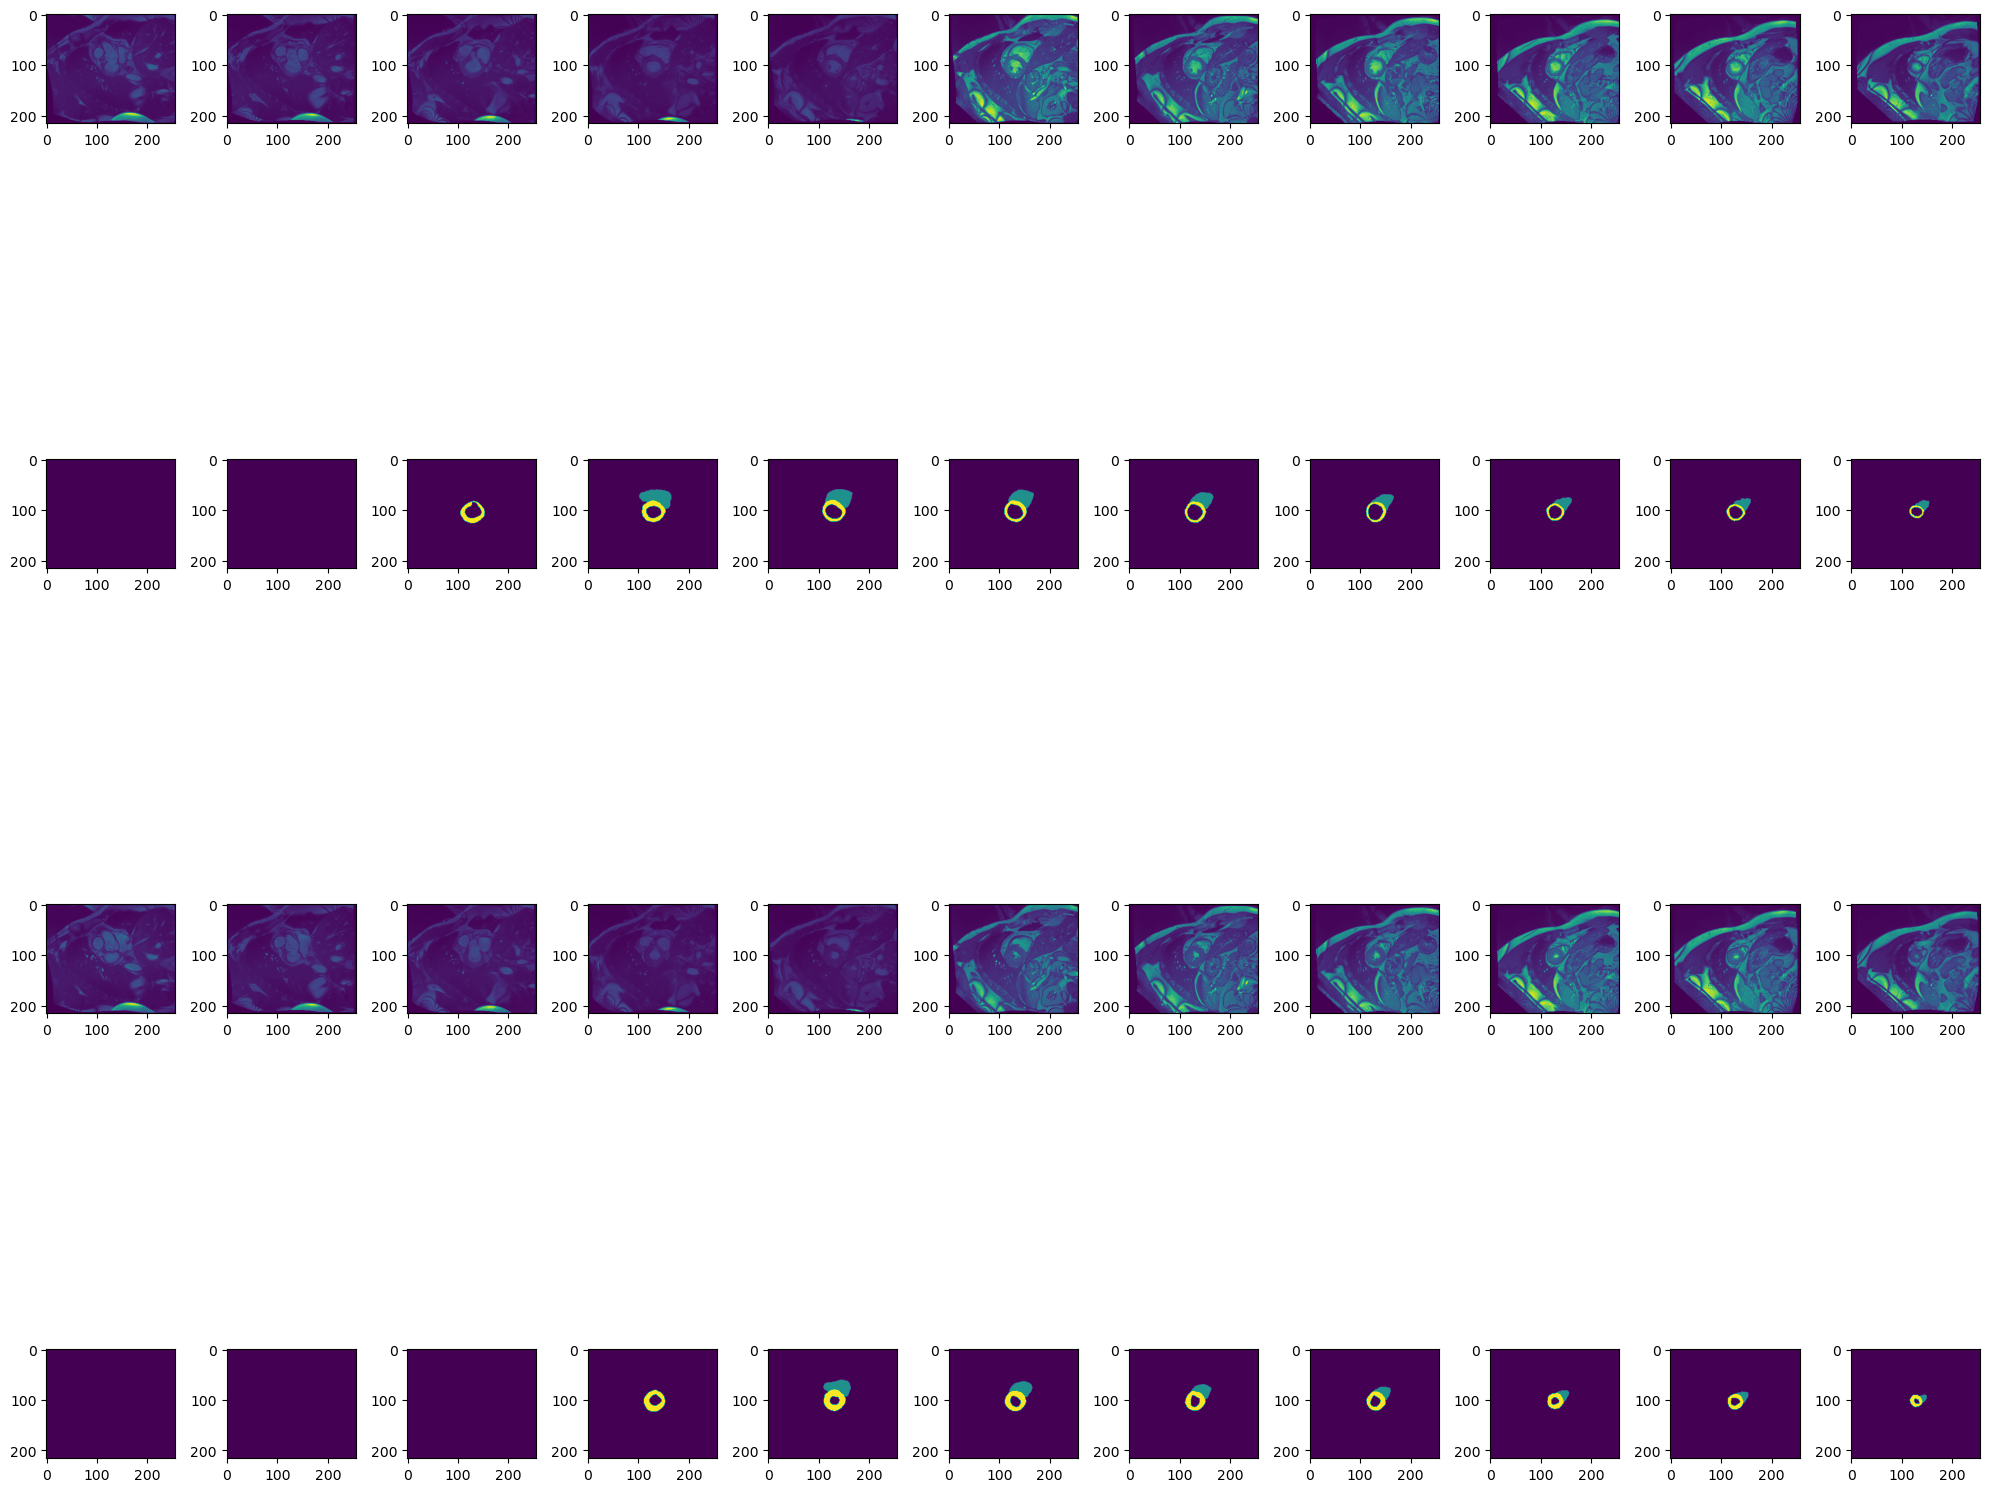

In [15]:
# Test Data exploration and visualization

display_random_subject_MRI_images_slices(Test_path, segmentation=False)


We observe that the active contour inside the myocardium muscle could be easely implemented to retrive the LV segmentation

In [54]:
def myocardium_centers(image_path, label):
    # Load the image
    image = nib.load(image_path).get_fdata()

    # Get the myocardium mask (myocardium label is 2)
    myocardium_mask = (image == label)

    # Calculate the center of mass of the myocardium mask for each slice
    centers = {}
    for z in range(myocardium_mask.shape[2]):
        if np.any(myocardium_mask[:, :, z]):
            center_of_mass = np.mean(np.argwhere(myocardium_mask[:, :, z]), axis=0)
            centers[z] = center_of_mass

    return centers

In [55]:
def apply_snake(image_path, centers, label=segmentation_label["Myocardium"] ,alpha=0.01, beta=1, gamma=0.01, iterations=100, smoothing=2, init_distance=0.7, w_edge=2, w_line=0):
    # Load the image and segmentation
    image = nib.load(image_path).get_fdata()

    # Convert image to grayscale and apply Gaussian smoothing
    smoothed_image = gaussian(image, sigma=smoothing)

    # Calculate snake for each slice containing myocardium
    snakes = {}
    for z, center in centers.items():
        # Find the myocardium boundary (label 2) in the segmentation
        myocardium = np.where(image[:, :, z] == label)

        # Calculate the distances between the center and all myocardium boundary points
        distances = np.sqrt((myocardium[0] - center[0])**2 + (myocardium[1] - center[1])**2)

        # Set the initial radius as half the mean distance
        initial_radius = init_distance * np.mean(distances)

        # Initialize the snake
        s = 2 * np.pi * np.arange(0, 1, 0.01)
        init_snake = np.array([center[0] + initial_radius * np.cos(s), center[1] + initial_radius * np.sin(s)]).T

        # Apply the snake to the smoothed image slice
        snake = active_contour(smoothed_image[:, :, z], init_snake, alpha=alpha, beta=beta, gamma=gamma, w_edge=w_edge, w_line=w_line, max_iterations=iterations)

        # Store the snake
        snakes[z] = snake

    return snakes


In [56]:
def plot_centers_snakes(image_path, centers, snakes):
    # Load the image
    image = nib.load(image_path).get_fdata()

    # Plot the 2D image slices
    for z, center in centers.items():
        image_slice = image[:, :, z]
        snake = snakes[z]

        plt.figure()
        plt.imshow(image_slice.T, cmap='gray', origin='lower')
        plt.scatter(center[0], center[1], c='red', marker='x', s=100)  # Plot the center point
        plt.plot(snake[:, 0], snake[:, 1], '-b', lw=2)  # Plot the snake
        plt.title(f'Snake on Image Slice {z}')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')

    plt.show()


<ipython-input-18-edd14ca51ecb>:25: FutureWarning: `max_iterations` is a deprecated argument name for `active_contour`. It will be removed in version 1.0. Please use `max_num_iter` instead.
  snake = active_contour(smoothed_image[:, :, z], init_snake, alpha=alpha, beta=beta, gamma=gamma, w_edge=w_edge, w_line=w_line, max_iterations=iterations)


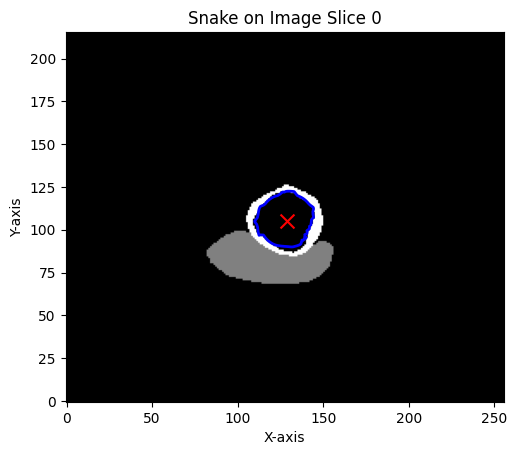

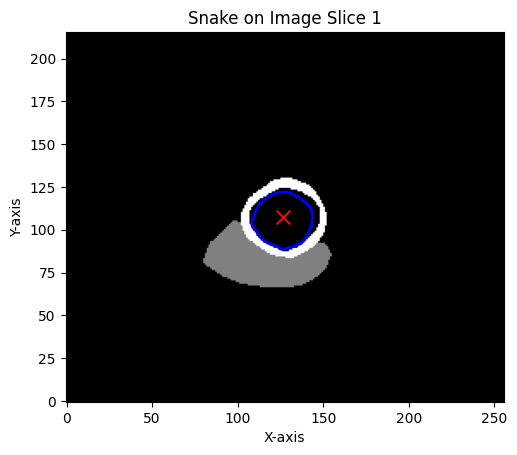

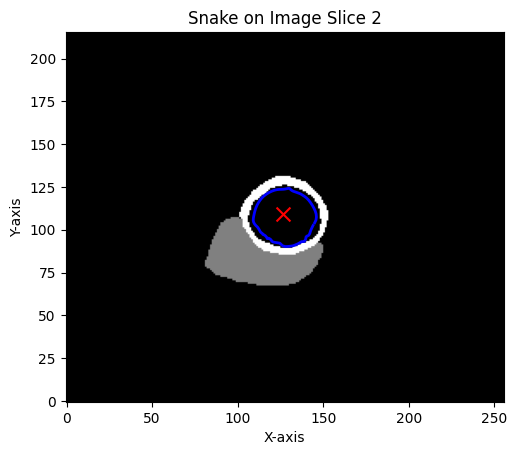

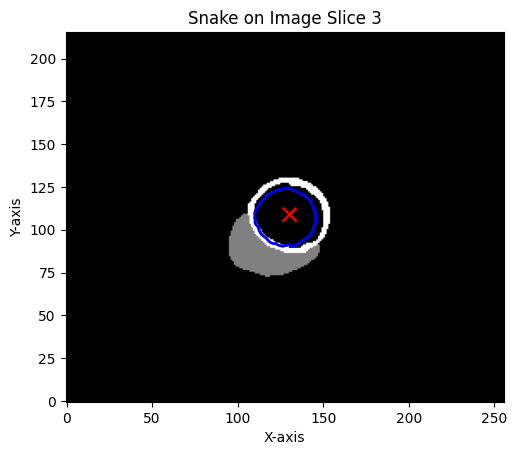

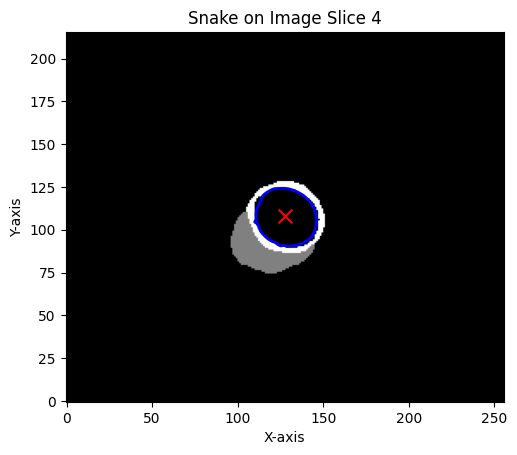

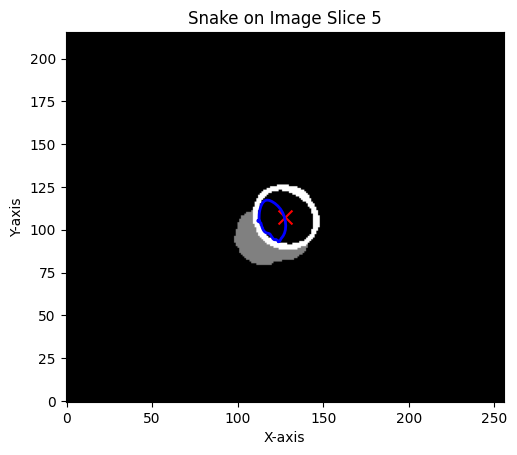

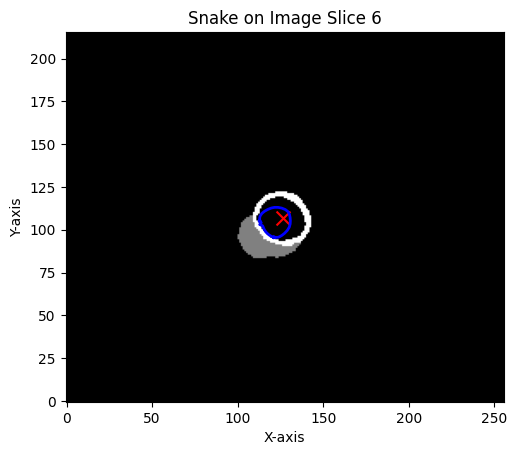

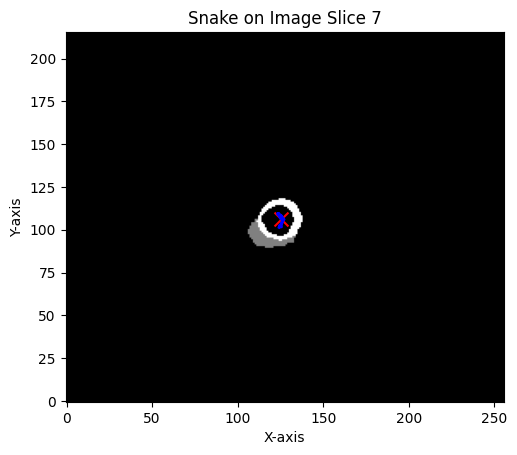

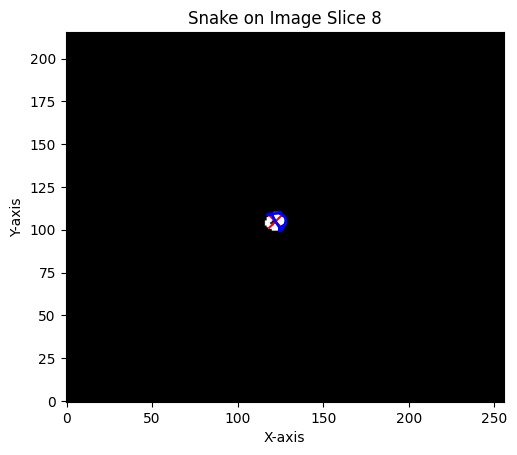

In [ ]:
# Path to the segmented image
segmentation_path = Test_path + "/"+ random_string + "/" + random_string + "_ED_seg.nii"

# Calculate the center of the myocardium for each slice containing myocardium
centers = myocardium_centers(segmentation_path,segmentation_label["Myocardium"])

# Apply the snake to the image using the myocardium centers
snakes = apply_snake(segmentation_path, centers, iterations=100)

# Plot the snakes on the image
plot_centers_snakes(segmentation_path, centers, snakes)


In [57]:
def fill_myocardium_background(image_path, myocardium_label=segmentation_label["Myocardium"], lv_label=segmentation_label["Left ventricle cavity"]):
    image = nib.load(image_path)
    img_data = image.get_fdata()
    filled_img_data = img_data.copy()
    centers = myocardium_centers(image_path, myocardium_label)

    for z, center in centers.items():
        int_center = np.asarray(np.round(center), dtype=int)
        filled_img_data[:, :, z] = flood_fill(filled_img_data[:, :, z], tuple(int_center), lv_label, connectivity=1)

    filled_img = nib.Nifti1Image(filled_img_data, image.affine)
    return filled_img


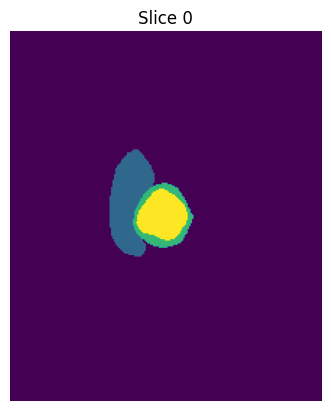

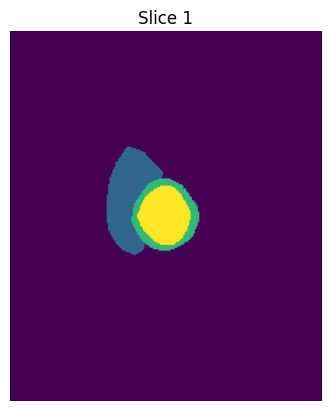

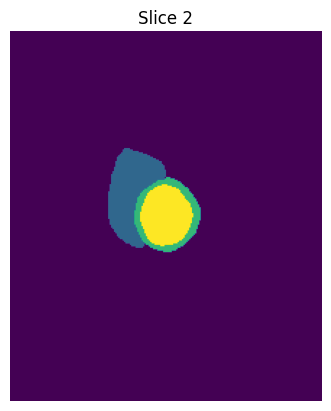

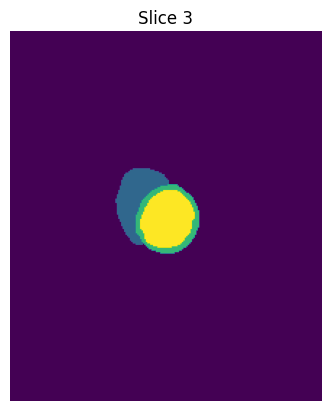

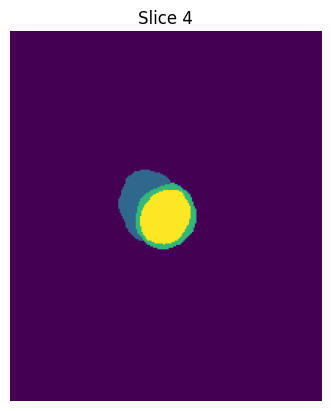

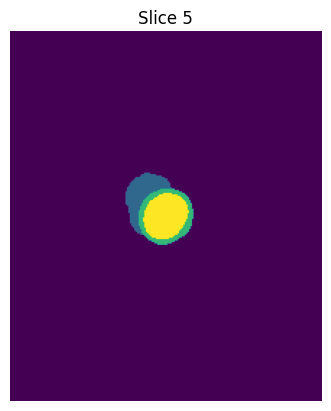

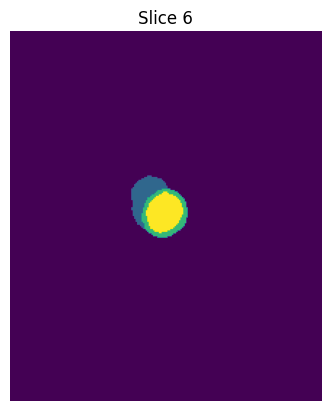

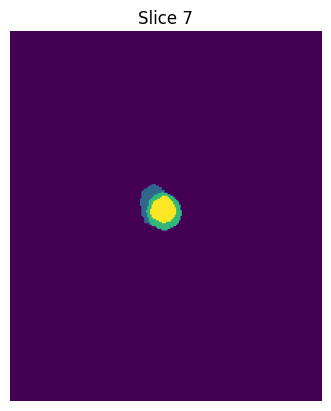

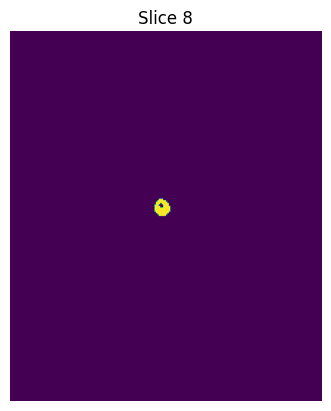

In [ ]:
# Verify the filling of the myocardium function on one image and plot it
image_path = Test_path + "/"+ random_string + "/" + random_string + "_ED_seg.nii"

filled_img_data = fill_myocardium_background(image_path, myocardium_label=segmentation_label["Myocardium"], lv_label=segmentation_label["Left ventricle cavity"])

save_path = "/content/drive/MyDrive/Colab Notebooks/filled_image.nii"
nib.save(filled_img_data, save_path)

img = nib.load(save_path)
img_data = img.get_fdata()

# Loop through each slice and plot
for z in range(img_data.shape[2]):
    plt.imshow(img_data[:, :, z])
    plt.title('Slice %d' % z)
    plt.axis('off')
    plt.show()


In [58]:
# Segment the LV for all the Test set

def left_ventricle_segmentation_test_set():
  start = 101
  stop = 151

  for i in range(subject_num_test_start,subject_num_test_stop+1):

    subject_num = str(i).zfill(3)
    image_path = Test_path + "/"+ subject_num + "/" + subject_num + "_ED_seg.nii"
    filled_img_data = fill_myocardium_background(image_path, myocardium_label=segmentation_label["Myocardium"], lv_label=segmentation_label["Left ventricle cavity"])
    save_path = Test_path + "/"+ subject_num + "/" + subject_num + "_LV_ED_seg.nii"
    nib.save(filled_img_data, save_path)

    image_path = Test_path + "/"+ subject_num + "/" + subject_num + "_ES_seg.nii"
    filled_img_data = fill_myocardium_background(image_path, myocardium_label=segmentation_label["Myocardium"], lv_label=segmentation_label["Left ventricle cavity"])
    save_path = Test_path + "/"+ subject_num + "/" + subject_num + "_LV_ES_seg.nii"
    nib.save(filled_img_data, save_path)

## Classification ##

In [40]:
# Lets first organise our input as X_train, y_train, X_test, y_test

def organize_data(training_features='training_features.csv', test_features='test_features.csv'):
  training_features_df = pd.read_csv(training_features)
  test_features_df = pd.read_csv(test_features)
  
  y_train_df = training_features_df['Category']
  y_train = y_train_df.values

  X_train_df = training_features_df.drop(['Category','Id'], axis=1)
  X_train = X_train_df.values

  X_test_df = test_features_df.drop(['Category','Id'], axis=1)
  X_test = X_test_df.values
  y_test = None

  X_test_df.head()

  return training_features_df, X_train_df, X_train, y_train_df, y_train, test_features_df, X_test_df, X_test, y_test

In [41]:
# Lets shuffle the data randomly

def shuffle_training_set(X_train, y_train):
  N,M = X_train.shape

  indeces = np.arange(0,N)
  np.random.shuffle(indeces)

  X_train = X_train[indeces[:]]
  y_train = y_train[indeces[:]]
  return X_train, y_train

In [42]:
# Standardization/Normalization

def normalize_features(X_train, X_test):
  #plt.figure(figsize=(10,10))
  #plt.boxplot(X_train,notch=True);

  normalizer = MinMaxScaler()
  normalizer.fit(X_train)
  X_train=normalizer.transform(X_train)
  X_test=normalizer.transform(X_test)

  #plt.figure(figsize=(10,10))
  #plt.boxplot(X_train,notch=True);
  return X_train,X_test

In [43]:
# Slip the training set in two in order to train a Random Forest Classifier and do cross-validation

def find_RFC_best_parameters_cross_validation(X_train, y_train, test_size=0.2, n_estimators=100, random_state=42):

  # Split the data into training and validation sets
  X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

  # Initialize the classifier
  RF = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

  p_grid_RF = {'n_estimators': [10,15,20,25,30,40,50], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

  grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
  grid_RF.fit(X_train_2, y_train_2)

  print("Best Validation Score: {}".format(grid_RF.best_score_))
  print("Best params: {}".format(grid_RF.best_params_))
  print("Random Forest test score :",grid_RF.score(X_val,y_val))
  return RF, grid_RF

In [44]:
# Fit the Random Forest Classifier to the training set

def RandomForestClassifierFitting(RF, grid_RF, X_train, y_train):
  RF = RandomForestClassifier(n_estimators=grid_RF.best_params_['n_estimators'], min_samples_leaf=grid_RF.best_params_['min_samples_leaf'], max_features=grid_RF.best_params_['max_features'], random_state=42)
  RF.fit(X_train, y_train)
  return RF


In [45]:
# Retrive a submission file out of the y_test

def predict_and_save_test_set_labels(RF, X_test, test_features_df, SubmissionName='SubmissionNicolasBoisseau.csv'):
  # Use the trained model to predict labels of the test set
  #y_pred = Tree.predict(X_test)
  y_pred = RF.predict(X_test)

  y_pred_df = pd.DataFrame(y_pred, columns=['Category'])
  y_pred_df['Category'] = y_pred_df['Category'].astype(int)
  y_pred_df = pd.concat([test_features_df['Id'], y_pred_df], axis=1)
  #y_pred_df.head()

  y_pred_df.to_csv(SubmissionName, index=False)
  return y_pred_df, y_pred

In [46]:
# High level classification function

def classify():
  training_features_df, X_train_df, X_train, y_train_df, y_train, test_features_df, X_test_df, X_test, y_test = organize_data()
  X_train, y_train = shuffle_training_set(X_train, y_train)
  X_train, X_test = normalize_features(X_train, X_test)
  RF, grid_RF = find_RFC_best_parameters_cross_validation(X_train, y_train, test_size=0.2, n_estimators=100, random_state=42)
  RF = RandomForestClassifierFitting(RF, grid_RF, X_train, y_train)
  y_pred_df, y_pred = predict_and_save_test_set_labels(RF, X_test, test_features_df)
  return y_pred, y_pred_df, RF, X_train_df


In [30]:
def observe_features_importances(RF, X_train_df):

    # Get the feature importances and sort them in descending order
    feature_importances = RF.feature_importances_
    sorted_idx = feature_importances.argsort()[::-1]

    # Get the column names of the feature dataframe
    feature_names = X_train_df.columns.tolist()

    # Print the feature ranking
    print("Feature ranking:")
    for i, idx in enumerate(sorted_idx):
        print("{0}. {1} ({2})".format(i+1, feature_names[idx], feature_importances[idx]))

    # Plot the feature importances as a bar chart
    import matplotlib.pyplot as plt
    plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
data = pd.read_csv('training_features.csv')

# Exclude 'Id' column
data_subset = data.drop(['Id'], axis=1)

# Group the data by the label
grouped_data = data_subset.groupby('Category')

# Calculate the mean and standard deviation for each feature within each group
feature_stats = grouped_data.mean().merge(grouped_data.std(), suffixes=('_mean', '_std'), on='Category')

# Reset the index of the DataFrame
feature_stats = feature_stats.reset_index()

# Get the list of columns (excluding 'Category')
columns = feature_stats.columns[1:]

# Define the colors for each category
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Iterate over the columns and create individual plots
for i in range(0, len(columns), 2):
    y_column = columns[i]
    yerr_column = columns[i+1]

    plt.figure(figsize=(8, 6))
    plt.bar(feature_stats['Category'], feature_stats[y_column], yerr=feature_stats[yerr_column], capsize=4, color=colors)
    plt.xlabel('Category')
    plt.ylabel(y_column)
    plt.title(f'{y_column} per Category')
    plt.xticks(feature_stats['Category'])
    plt.show()
